In [1]:
# ! pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance


In [ ]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

import os
import yfinance as yf
warnings.filterwarnings("ignore")

from backtest_functions_v2 import *

In [97]:
news = pd.read_parquet("/workspaces/fyp/crypto_news/data/3b.cryptonews_absa.parquet")
news

,title,text,source_name,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa
index,,,,,,,,,,
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,0.5,0.0,0.0,0.0,0.0,0.0
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,0.0,0.5,0.0,0.0,0.7,0.0
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,0.0,0.3,0.0,0.5,0.7,0.0
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,0.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
159481,XRP News Today: BTC Hits $91k; Will SEC Appeal...,"XRP price drops below $2, weighed by SEC appea...",FXEmpire,2024-12-31 05:34:31+00:00,0.0,0.0,0.0,0.0,0.0,0.0
159482,Tether Moves Bitcoin Worth $780M to Reserve in...,"Tether, the issuer of the world's most widely ...",Cryptonews,2024-12-31 05:28:54+00:00,0.0,0.0,0.0,0.0,0.0,0.0
159483,The Bull Run Continues; Bitfinex Projects $200...,Digital asset exchange Bitfinex predicted an u...,Zycrypto,2024-12-31 05:21:59+00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
def news_handling_hour(path):
    news = pd.read_parquet(path)

    news["date"] = pd.to_datetime(news["date"])
    news_absa = news[["date","tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa"]]
    news_absa["date_hour"] = news_absa['date'].dt.floor('H')

    entries_per_hour = news_absa.groupby('date_hour').size()

    all_hours = pd.date_range(start=news_absa["date_hour"].min(),end= news_absa["date_hour"].max(), freq="H")

    entries_per_hour = entries_per_hour.reindex(all_hours, fill_value=0)

    news_absa['entries_per_hour'] = news_absa['date_hour'].map(entries_per_hour)
    # news_absa['entries_per_hour'] = news_absa['entries_per_hour'].fillna(0) 

    # grouped_news_by_hour = news.groupby('date_hour').size()
    sentiment_columns = [
    'tanalysis_absa',
    'economy_absa',
    'regulation_absa',
    'technology_absa',
    'adoption_absa'
    ]

    # 2. Compute the average sentiment for each entry (row) by averaging across the sentiment columns
    news_absa['Average Sentiment'] = news_absa[sentiment_columns].mean(axis=1)
    news_absa['Average Sentiment'].fillna(0, inplace=True)
    news_absa['Sentiment_6HR'] = news_absa['Average Sentiment'].rolling(window=6, min_periods=1).mean()
    news_absa['Sentiment_12HR'] = news_absa['Average Sentiment'].rolling(window=12, min_periods=1).mean()
    news_absa['Sentiment_24HR'] = news_absa['Average Sentiment'].rolling(window=24, min_periods=1).mean()

    return news_absa


In [99]:
def MutualInfo(df):
  X = df.drop(["target","date"], axis=1)
  y = df["target"]
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores.sort_values(ascending=False, inplace=True)
  print(mi_scores)

In [100]:
def filling_empty_news(df):
# Create a complete range of hours
    df = df.sort_values('date_hour').reset_index(drop=True)

    start_time = pd.to_datetime("2021-01-01 10:00:00+00:00")
    end_time = df['date_hour'].max()
    full_hours = pd.date_range(start=start_time, end=end_time, freq='H')

    # Create a complete DataFrame with all hours
    full_df = pd.DataFrame({'date_hour': full_hours})

    # Merge with original data
    merged_df = pd.merge(full_df, df, on='date_hour', how='left')

    # Function to fill missing values with mean of previous 3 entries
    def fill_with_previous_mean(df, column):
        for i in range(len(df)):
            if pd.isna(df.loc[i, column]):
                # Get previous 3 entries or as many as available
                start_idx = max(0, i-3)
                previous_values = df.loc[start_idx:i-1, column].dropna()
                
                if len(previous_values) > 0:
                    df.loc[i, column] = previous_values.mean()
        return df

    def fill_with_previous_value(df, column):
        for i in range(len(df)):
            if pd.isna(df.loc[i, column]):
                # Get previous 3 entries or as many as available
                start_idx = max(0, i)
                previous_values = df.loc[start_idx:i-1, column].dropna()
                
                if len(previous_values) > 0:
                    df.loc[i, column] = previous_values.mean()
        return df

    def fill_with_previous_value(df, column):
        # Create a copy of the dataframe to avoid modifying the original
        df_filled = df.copy()
        
        # Iterate through each row
        for i in range(1, len(df_filled)):  # Start from index 1 (second row)
            # Check if the current value is missing
            if pd.isna(df_filled.loc[i, column]):
                # Fill with the previous value
                df_filled.loc[i, column] = df_filled.loc[i-1, column]
        
        # Special case for the first row if it's missing
        if pd.isna(df_filled.loc[0, column]) and len(df_filled) > 1:
            # If the first row is missing, use the next available value
            for j in range(1, len(df_filled)):
                if not pd.isna(df_filled.loc[j, column]):
                    df_filled.loc[0, column] = df_filled.loc[j, column]
                    break
        
        return df_filled
    def fill_with_zero(df, column):
        # Create a copy of the dataframe to avoid modifying the original
        df_filled = df.copy()
        
        # Replace NaN values with 0 in the specified column
        df_filled[column] = df_filled[column].fillna(0)
        
        return df_filled
    
    # Fill missing values for each column
    columns_to_fill = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 
                    'technology_absa', 'adoption_absa']
    
    for col in columns_to_fill:
        merged_df = fill_with_previous_mean(merged_df, col)
    
    col_filled_by_prev_value = ["Sentiment_6HR","Sentiment_12HR", "Sentiment_24HR", "Average Sentiment"]
    for col in col_filled_by_prev_value:
        merged_df = fill_with_previous_value(merged_df,col)    
    
    col_filled_by_zero = ["entries_per_hour"]
    for col in col_filled_by_zero:
        merged_df = fill_with_zero(merged_df,col)
    return merged_df


In [101]:
news_by_hour = news_handling_hour("/workspaces/fyp/crypto_news/data/3b.cryptonews_absa.parquet")

# Display the filtered data
news_by_hour = news_by_hour.groupby([news_by_hour['date_hour']], as_index=False).mean()

news_by_hour = news_by_hour.drop(['date'], axis=1)
news_by_hour = news_by_hour[:-5]
news_by_hour


,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
0,2021-01-01 06:00:00+00:00,0.850000,0.0,0.0,0.0,0.15,2.0,0.200000,0.143333,0.170833,0.194583
1,2021-01-01 08:00:00+00:00,0.400000,0.0,0.0,0.0,0.50,2.0,0.180000,0.163333,0.179167,0.192500
2,2021-01-01 09:00:00+00:00,-0.050000,0.0,0.0,0.0,0.40,2.0,0.070000,0.193333,0.191667,0.193750
3,2021-01-01 10:00:00+00:00,0.766667,0.0,0.0,0.0,0.30,3.0,0.213333,0.198889,0.216667,0.177500
4,2021-01-01 11:00:00+00:00,1.000000,0.0,0.0,0.0,0.00,2.0,0.200000,0.190000,0.202500,0.179167
...,...,...,...,...,...,...,...,...,...,...,...
32090,2024-12-31 19:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,6.0,0.000000,0.000000,0.000000,0.000000
32091,2024-12-31 20:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,6.0,0.000000,0.000000,0.000000,0.000000
32092,2024-12-31 21:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,3.0,0.000000,0.000000,0.000000,0.000000
32093,2024-12-31 22:00:00+00:00,0.000000,0.0,0.0,0.0,0.00,4.0,0.000000,0.000000,0.000000,0.000000


In [102]:
news_by_hour_filled = filling_empty_news(news_by_hour)
news_by_hour_filled

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
0,2021-01-01 10:00:00+00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,0.177500
1,2021-01-01 11:00:00+00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,0.179167
2,2021-01-01 12:00:00+00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,0.175471
3,2021-01-01 13:00:00+00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,0.172581
4,2021-01-01 14:00:00+00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,0.155110
...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000
35050,2024-12-31 20:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000
35051,2024-12-31 21:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,0.000000
35052,2024-12-31 22:00:00+00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,0.000000


In [103]:
news_by_hour_filled.to_parquet('/workspaces/fyp/crypto_news/data/6.News_by_hour_filled.parquet')  
news_by_hour.to_parquet('/workspaces/fyp/crypto_news/data/6.News_by_hour.parquet')  


In [104]:
# Simple version
print("Missing values by column:")
print(news_by_hour.isna().sum())
print("\nTotal missing values:", news_by_hour.isna().sum().sum())


Missing values by column:
date_hour            0
tanalysis_absa       0
economy_absa         0
regulation_absa      0
technology_absa      0
adoption_absa        0
entries_per_hour     0
Average Sentiment    0
Sentiment_6HR        0
Sentiment_12HR       0
Sentiment_24HR       0
dtype: int64

Total missing values: 0


In [105]:
def generate_signals(df):
  df['date'] = pd.to_datetime(df['date'])

  # Generate signal column
  # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
  df['signal'] = df['Predicted Return'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
  return df

In [106]:
btc_ner = pd.read_parquet("/workspaces/fyp/crypto_news/data/4d.cryptonews_top20_events_grouped.parquet")
start_date = pd.to_datetime("2021-01-01 10:00:00")
end_date = pd.to_datetime("2025-01-01 00:00:00")
btc_ner
# Filter the DataFrame to keep only entries within the specified date range
btc_ner = btc_ner.loc[(btc_ner.index >= start_date) & (btc_ner.index < end_date)]

btc_ner

,Bitcoin Halving,Bitcoin halving,Bitcoin ETF approval,Bitcoin ETF Approval,Bitcoin ETF,2021 Berkshire Hathaway Annual Shareholders Meeting,FOMC meeting,crypto winter,Spot Bitcoin ETF Approval,spot Bitcoin ETF approval,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 11:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 14:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
btc_price.index = pd.to_datetime(btc_price.index)

btc_price

,open,high,low,close,volume,return_forward
timestamp,,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.000000,0E-20
...,...,...,...,...,...,...
2025-01-06 19:00:00,101805.00,102089.00,101665.00,101853.00,129.918554,0.00278833220425515200
2025-01-06 20:00:00,101892.00,102360.00,101892.00,102137.00,190.003279,-0.00473873327001967945
2025-01-06 21:00:00,102185.00,102407.00,101633.00,101653.00,48.243388,0.00378739437104659970


In [108]:
btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
data = pd.read_parquet("/workspaces/fyp/crypto_news/data/6.News_by_hour_filled.parquet")

data['date_hour'] = data['date_hour'].dt.tz_localize(None)
# news_by_hour.index = news_by_hour.index.tz_localize(None)
btc_ner.index = btc_ner.index.tz_localize(None)

btc_price.index = pd.to_datetime(btc_price.index)


# Map btc_price["return_forward_1d"] to data["date"] to create the target column
data["target"] = data["date_hour"].map(btc_price["return_forward"])

# data["target"] = data["target"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# Optional: Fill missing values in target with 0

data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,0.177500,0.00011763861008622260
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,0.179167,-0.00247456535252905630
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,0.175471,-0.00328966649836125220
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,0.172581,0.00706464171240691160
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,0.155110,0.00121368921223582020
...,...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641
35050,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110
35051,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572
35052,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,0.000000,0.00093253585439578110


In [ ]:
data.to_parquet('/workspaces/fyp/crypto_news/data/7.News_by_hour_filled_return.parquet')  

btc_price = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price.parquet")
ndata = pd.read_parquet("/workspaces/fyp/crypto_news/data/6.News_by_hour.parquet")

ndata['date_hour'] = ndata['date_hour'].dt.tz_localize(None)

btc_price.index = pd.to_datetime(btc_price.index)

# Map btc_price["return_forward_1d"] to data["date"] to create the target column
ndata["target"] = ndata["date_hour"].map(btc_price["return_forward"])

news_by_hour.to_parquet('/workspaces/fyp/crypto_news/data/7.News_by_hour_return.parquet')  


In [ ]:
data['date_hour'] = pd.to_datetime(data['date_hour'])

# Reset index of btc_ner to make 'date_hour' a column
btc_ner_reset = btc_ner.reset_index()

# Merge data and btc_ner on 'date_hour'
data = pd.merge(data, btc_ner_reset, on='date_hour', how='inner')

data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [111]:
data.to_parquet('/workspaces/fyp/crypto_news/data/7a.News_by_hour_filled_return_ner.parquet')

In [113]:
#Missing Target
target_col = "target"

train_startdate = pd.to_datetime("2021-01-01 10:00:00")
train_enddate = pd.to_datetime("2022-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
train_data = data[(data['date_hour'] >= train_startdate) & (data['date_hour'] <= train_enddate)]

val_startdate = pd.to_datetime("2023-01-01 00:00:00")
val_enddate = pd.to_datetime("2023-12-31 23:00:00")

# Validation: 2023-01-01 to 2023-12-31
validation_data = data[(data['date_hour'] >= val_startdate) & (data['date_hour'] <= val_enddate)]

test_startdate = pd.to_datetime("2024-01-01 00:00:00")
test_enddate = pd.to_datetime("2024-12-31 23:00:00")

# Test: 2024-01-01 to 2024-12-31
test_data = data[(data['date_hour'] >= test_startdate) & (data['date_hour'] <= test_enddate)]

features = ["tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa","entries_per_day", "Average Sentiment", "Sentiment_6HR", "Sentiment_12HR", "Sentiment_24HR"]
target_col = 'target'

test_data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
23498,2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,0.033333,...,0,0,0,0,0,0,0,0,0,0
23499,2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,-0.001111,...,0,0,0,0,0,0,0,0,0,0
23500,2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,0.043333,...,0,0,0,0,0,0,0,0,0,0
23501,2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,0.027500,...,0,0,0,0,0,0,0,0,0,0
23502,2024-01-01 05:00:00,-0.700000,0.0,0.300000,0.0,0.200000,1.0,-0.040000,0.040000,-0.008333,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.0,0.000000,0.0,0.000000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [114]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date_hour                                              0
tanalysis_absa                                         0
economy_absa                                           0
regulation_absa                                        0
technology_absa                                        0
adoption_absa                                          0
entries_per_hour                                       0
Average Sentiment                                      0
Sentiment_6HR                                          0
Sentiment_12HR                                         0
Sentiment_24HR                                         0
target                                                 0
Bitcoin Halving                                        0
Bitcoin halving                                        0
Bitcoin ETF approval                                   0
Bitcoin ETF Approval                                   0
Bitcoin ETF                                            0
2021 Berkshire Hathaway Annual 

In [115]:
feature_cols =["tanalysis_absa","economy_absa","regulation_absa", "Sentiment_6HR", "Sentiment_12HR", "Sentiment_24HR"]
target_col = "target"

X_train = train_data[feature_cols]
y_train = train_data[target_col]

# Validation Data
X_val = validation_data[feature_cols]
y_val = validation_data[target_col]

# Test Data
X_test = test_data[feature_cols]
y_test = test_data[target_col]



# RFR

In [116]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

X_train_smoothed = X_train.copy()
numeric_columns = X_train_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_train_smoothed[f'{col}_ewm'] = X_train_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()
X_train_smoothed

rf.fit(X_train_smoothed, y_train)


RandomForestRegressor(random_state=42)

In [117]:
#Evaluate Model by Validation

X_val_smoothed = X_val.copy()
numeric_columns = X_val_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_val_smoothed[f'{col}_ewm'] = X_val_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_val = rf.predict(X_val_smoothed)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.000027
R-squared: -0.2746


In [118]:
# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],

}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf_reg = grid_search.best_estimator_
best_rf_reg.fit(X_train_smoothed, y_train)


Best Parameters: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestRegressor(max_depth=2, random_state=42)

In [119]:
importances = best_rf_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


                Feature  Importance
11   Sentiment_24HR_ewm    0.336274
9     Sentiment_6HR_ewm    0.147530
5        Sentiment_24HR    0.140541
10   Sentiment_12HR_ewm    0.121222
6    tanalysis_absa_ewm    0.100563
3         Sentiment_6HR    0.056257
4        Sentiment_12HR    0.032163
8   regulation_absa_ewm    0.023983
7      economy_absa_ewm    0.019084
0        tanalysis_absa    0.017234
2       regulation_absa    0.004666
1          economy_absa    0.000484


In [120]:
validation_data

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
15566,2023-01-01 01:00:00,0.000000,-0.15,0.350000,0.0,0.500000,2.0,0.140,0.091667,0.101667,...,0,0,0,0,0,0,0,0,0,0
15567,2023-01-01 02:00:00,0.000000,0.00,0.000000,0.0,0.000000,1.0,0.000,0.056667,0.078333,...,0,0,0,0,0,0,0,0,0,0
15568,2023-01-01 04:00:00,0.700000,0.00,0.000000,0.0,0.000000,1.0,0.140,0.080000,0.070000,...,0,0,0,0,0,0,0,0,0,0
15569,2023-01-01 07:00:00,0.000000,0.00,0.000000,0.0,1.000000,1.0,0.200,0.166667,0.113333,...,0,0,0,0,0,0,0,0,0,0
15570,2023-01-01 08:00:00,0.400000,0.00,0.000000,0.0,0.350000,2.0,0.150,0.115000,0.046667,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23493,2023-12-31 18:00:00,0.250000,0.00,-0.175000,0.0,0.000000,4.0,0.015,0.079167,0.052917,...,0,0,0,0,0,0,0,0,0,0
23494,2023-12-31 19:00:00,0.266667,0.00,0.066667,0.0,0.366667,3.0,0.140,0.067778,-0.007778,...,0,0,0,0,0,0,0,0,0,0
23495,2023-12-31 20:00:00,0.000000,0.00,0.800000,0.0,1.000000,1.0,0.360,0.086667,-0.026667,...,0,0,0,0,0,0,0,0,0,0
23496,2023-12-31 21:00:00,0.000000,0.00,-0.500000,0.0,-0.700000,1.0,-0.240,-0.006667,-0.041667,...,0,0,0,0,0,0,0,0,0,0


Overall Annual Return: 0.0%
Overall Annual Sharpe Ratio: nan
Maximum Drawdown: 0.0 %
Alpha: 0.0
Beta: 0.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023            0.0         0.0          0.0           0.0            NaN


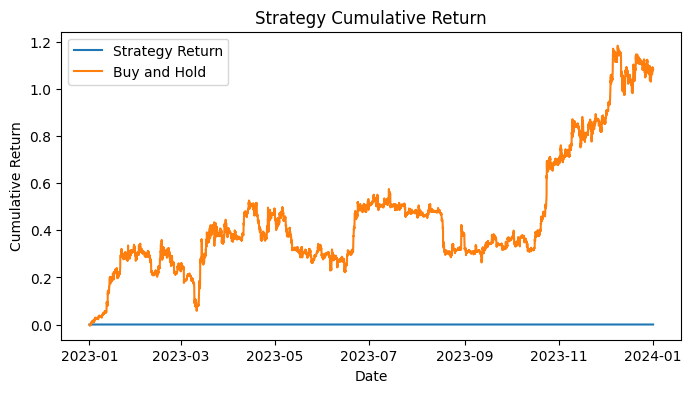

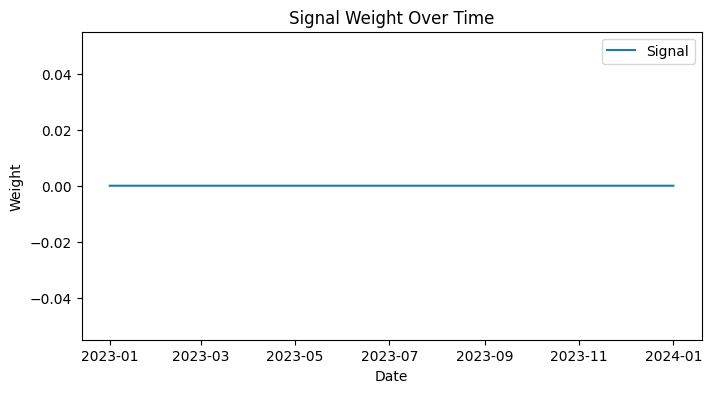

In [121]:
temp = pd.DataFrame()
temp["date_hour"] = validation_data["date_hour"]
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x >= 1 else (-1 if x <= -1 else 0))

rfr_bt = temp
rfr_bt['date'] = pd.to_datetime(rfr_bt['date_hour'])

rfr_bt.set_index('date', inplace=True)


run_backtest(rfr_bt)




# XGB

In [122]:
from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_xgb = le.fit_transform(y_train)
# y_val = le.fit_transform(y_val)
# y_test = le.fit_transform(y_test)


xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_smoothed, y_train)
#Evaluate Model by Validation
y_pred_val = xgb.predict(X_val_smoothed)

mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')

Validation Set Metrics:
MSE: 0.000029
R-squared: -0.3868


In [ ]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=1  # Use all available CPU cores
)
grid_search.fit(X_train_smoothed, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)
best_xgb_reg = grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 100}
Best Score (Negative MSE): -6.917564506945765e-05


Overall Annual Return: 44.9%
Overall Annual Sharpe Ratio: 1.1041
Maximum Drawdown: -19.23 %
Alpha: 0.4694
Beta: 0.079

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.448953    0.413199     0.078962      0.384871       1.104068


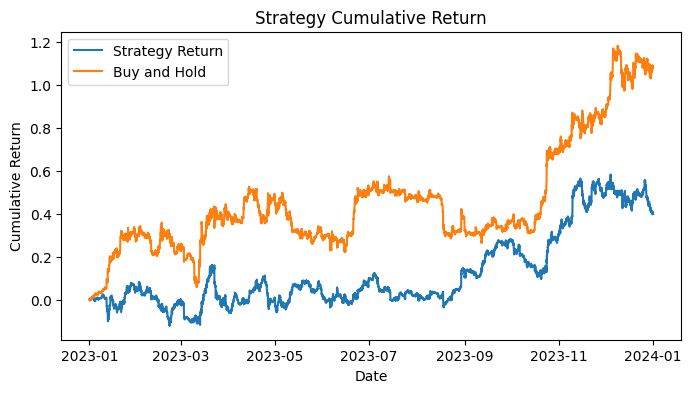

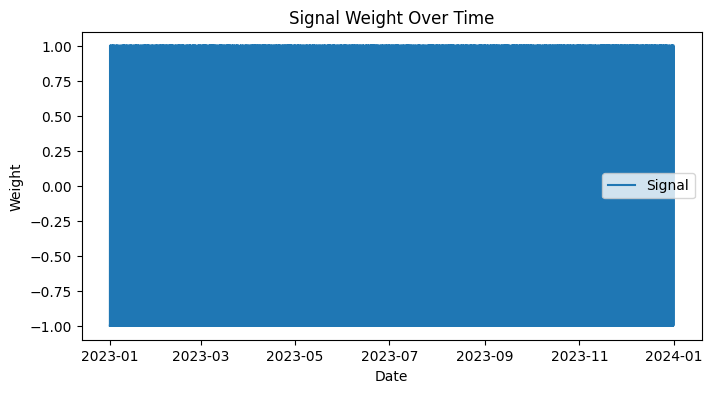

In [124]:
temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_val
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = validation_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
temp['date'] = x['date']

xgb_bt = temp


xgb_bt.set_index('date', inplace=True)


run_backtest(xgb_bt)



In [125]:
importances = best_xgb_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_smoothed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


                Feature  Importance
11   Sentiment_24HR_ewm    0.184384
5        Sentiment_24HR    0.125838
7      economy_absa_ewm    0.105697
9     Sentiment_6HR_ewm    0.098407
6    tanalysis_absa_ewm    0.096316
0        tanalysis_absa    0.082585
8   regulation_absa_ewm    0.079696
3         Sentiment_6HR    0.071766
2       regulation_absa    0.067317
4        Sentiment_12HR    0.049161
1          economy_absa    0.038833
10   Sentiment_12HR_ewm    0.000000


# RFR Test

In [126]:
X_test

,tanalysis_absa,economy_absa,regulation_absa,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR
23498,-0.300000,0.0,0.000000,-0.076667,0.033333,-0.032500
23499,-0.233333,0.0,-0.066667,-0.104444,-0.001111,-0.015000
23500,0.250000,0.0,-0.500000,0.055833,0.043333,0.021458
23501,0.000000,0.0,-0.450000,0.100000,0.027500,0.045833
23502,-0.700000,0.0,0.300000,0.040000,-0.008333,0.015000
...,...,...,...,...,...,...
32087,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
32088,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
32089,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
32090,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [127]:
model = best_rf_reg

X_test_smoothed = X_test.copy()
numeric_columns = X_test_smoothed.select_dtypes(include=['float64', 'int64']).columns

# Basic EWM smoothing
for col in numeric_columns:
    if col != 'entries_per_day':  # Skip grouping variable
        X_test_smoothed[f'{col}_ewm'] = X_test_smoothed[col].ewm(
            span=3,           # Adjustable parameter
            min_periods=1,    # Minimum number of observations
            adjust=True       # Adjust for bias
        ).mean()

y_pred_test = model.predict(X_test_smoothed)


temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = test_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

x = x.reset_index(drop=True)
x['signal'] = temp['signal']
y_pred_test

array([-1.38139888e-04, -1.37759051e-04, -4.58402741e-05, ...,
       -1.19893287e-04, -1.19893287e-04, -1.19893287e-04])

In [128]:
signal_counts = x['signal'].value_counts()
print(signal_counts)



signal
 1    4586
 0    2103
-1    1905
Name: count, dtype: int64


Overall Annual Return: 32.64%
Overall Annual Sharpe Ratio: 0.8409
Maximum Drawdown: -29.55 %
Alpha: 0.0953
Beta: 0.2983

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.326449    0.463663     0.298258      0.091068       0.840929


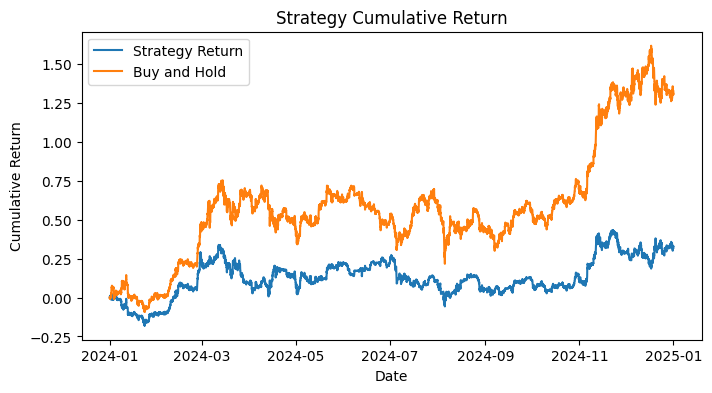

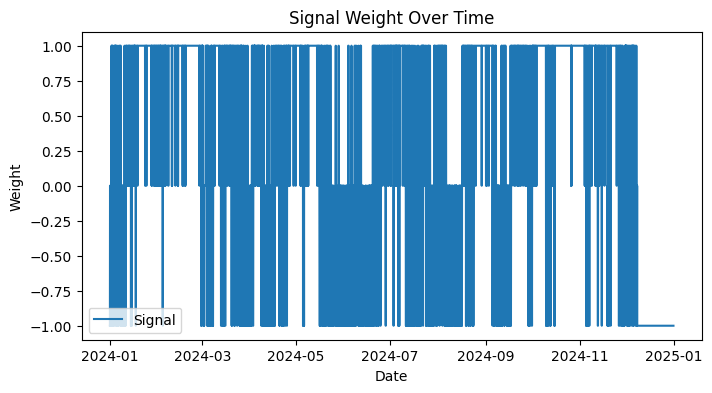

In [129]:
temp['date'] = x['date']

rfr_bt_test = temp

rfr_bt_test.set_index('date', inplace=True)


run_backtest(rfr_bt_test)
rfr_result = test_data
rfr_result["signal"] = temp["signal"]
rfr_result.to_parquet(f'/workspaces/fyp/crypto_news/data/8.rfr_result.parquet')  


In [130]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_test, y_pred_test)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.000033
R-squared: -0.0100


# XGB TEST

In [131]:
model = best_xgb_reg
y_pred_test = model.predict(X_test_smoothed)



temp = pd.DataFrame()
x = pd.DataFrame()
temp['Predicted return'] = y_pred_test
temp['signal'] = temp['Predicted return'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
x['date'] = test_data["date_hour"]
x['date'] = pd.to_datetime(x['date'])

y_pred_test


array([-9.7669232e-05, -8.6312437e-05, -4.3395863e-05, ...,
       -1.7524383e-04, -1.7524383e-04, -1.7524383e-04], dtype=float32)

In [132]:
temp["signal"]

0       0
1       0
2       0
3      -1
4      -1
       ..
8589   -1
8590   -1
8591   -1
8592   -1
8593   -1
Name: signal, Length: 8594, dtype: int64

Overall Annual Return: -29.86%
Overall Annual Sharpe Ratio: -0.5769
Maximum Drawdown: -49.29 %
Alpha: -0.2883
Beta: 0.0838

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.298644    0.444079     0.083789     -0.340156      -0.576934


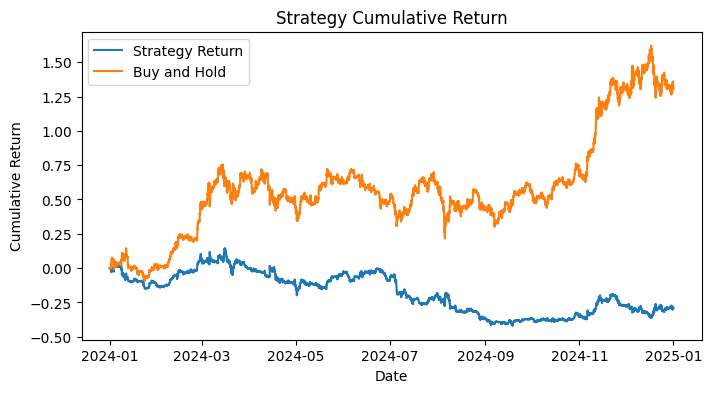

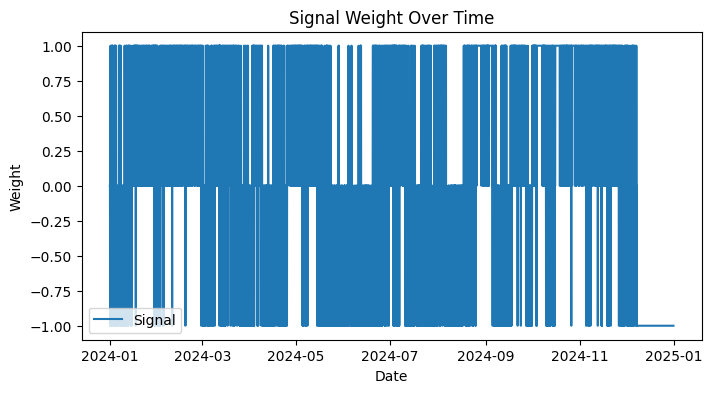

In [133]:
x = x.reset_index(drop=True)
temp['date'] = x['date']
xgb_bt_test = temp
xgb_result = test_data
xgb_result = xgb_result.reset_index()


xgb_result["signal"] = temp["signal"]
xgb_result.to_parquet('/workspaces/fyp/crypto_news/data/8.xgb_result.parquet')  
xgb_bt_test.set_index('date', inplace=True)
run_backtest(xgb_bt_test)


In [134]:
xgb_result

,index,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,...,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election,signal
0,23498,2024-01-01 01:00:00,-0.300000,0.0,0.000000,0.0,0.200000,1.0,-0.020000,-0.076667,...,0,0,0,0,0,0,0,0,0,0
1,23499,2024-01-01 02:00:00,-0.233333,0.0,-0.066667,0.0,0.333333,3.0,0.006667,-0.104444,...,0,0,0,0,0,0,0,0,0,0
2,23500,2024-01-01 03:00:00,0.250000,0.0,-0.500000,0.0,-0.175000,4.0,-0.085000,0.055833,...,0,0,0,0,0,0,0,0,0,0
3,23501,2024-01-01 04:00:00,0.000000,0.0,-0.450000,0.0,0.150000,2.0,-0.060000,0.100000,...,0,0,0,0,0,0,0,0,0,-1
4,23502,2024-01-01 05:00:00,-0.700000,0.0,0.300000,0.0,0.200000,1.0,-0.040000,0.040000,...,0,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,32087,2024-12-31 19:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1
8590,32088,2024-12-31 20:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1
8591,32089,2024-12-31 21:00:00,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1
8592,32090,2024-12-31 22:00:00,0.000000,0.0,0.000000,0.0,0.000000,4.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,-1


In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f'Test Set Metrics:')
print(f'MSE: {mse:.6f}')
print(f'R-squared: {r2:.4f}')

Test Set Metrics:
MSE: 0.000032
R-squared: -0.0013
